In [5]:
import numpy as np
import pickle as p
from matplotlib import pyplot as plt
from glob import glob as g
from pprint import pprint as pp
from tqdm import tqdm
import mdtraj as md
import h5py as h
import torch

hdf = h.File("../data/cov_cmaps_hdf.h5")
models = g("../models/*/*.pickle")
pp(models)

['../models/300_epochs/pooled35-21-08-25_0003.pickle',
 '../models/50_epochs/pooled35-21-08-25_1532.pickle']


In [3]:
nn = p.load(models[0])

def strip(traj):                                                                                                                                                                      
    for res in traj.top.residues:                                                                                                                                                         
        if res.name == "ALA":                                                                                                                                                             
            zero_idx = res.index                                                                                                                                                                                                                                                                                                                       
            break                                                                                                                                                                         
    res_range = range(zero_idx,zero_idx+575)                                                                                                                                              
    atoms = []                                                                                                                                                                            
    for i in res_range:                                                                                                                                                                   
        for atom in traj.top._residues[i].atoms:                                                                                                                                          
            atoms.append(atom.index)                                                                                                                                                      
    return traj.atom_slice(atoms)

def get_pooled_atom_names(traj):
    def res_name(res):
        return f"{res.name}-{res.resSeq}"
    return [res_name(r) for r in traj.top.residues]

def pool_arr(arr,pool_size=25,cutoff=0.0,preapply=0.8):             
    shape = arr.shape
    if preapply:
        arr = arr < preapply
    try:                    
        assert shape[0] == shape[1]          
        shape = shape[0]                  
    except AssertionError:
        print("Only works for square arrays")
        raise NotImplementedError
    if shape % pool_size != 0:
        print("Please change pool_size\n"
              "None Integer division error")
        raise ArithmeticError
    iters = int(shape/pool_size)
    pooled = np.empty((iters,iters))
    for i in range(iters):
        ilow = i*pool_size
        ihgh = (i+1)*pool_size
        for j in range(iters):
            jlow = j*pool_size
            jhgh = (j+1)*pool_size
            cur_arr = arr[ilow:ihgh,jlow:jhgh]
            pooled[i,j] = 1 if np.average(cur_arr) > cutoff else 0
    return pooled

dp = "/mnt/data2/cov_sims"
pdb_ref = g(dp+"/*/*/*.pdb")[3]
ref = strip(md.load(pdb_ref))
res_names = get_pooled_atom_names(ref)
res_names[1] = res_names[1].replace("CY1","CYS")

In [4]:
a = [*hdf["data"].keys()]
a = a[0]
cmap = hdf["data"][a][0]
cmap.shape

(575, 575)

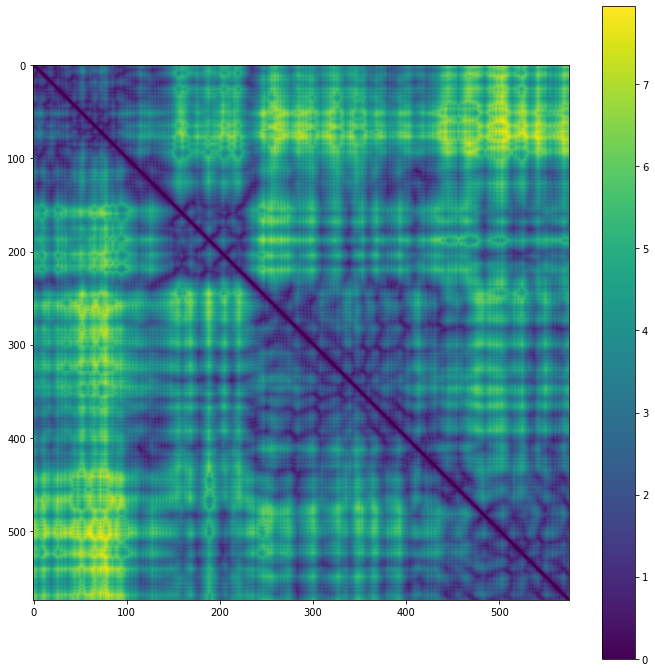

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(cmap)
plt.colorbar()

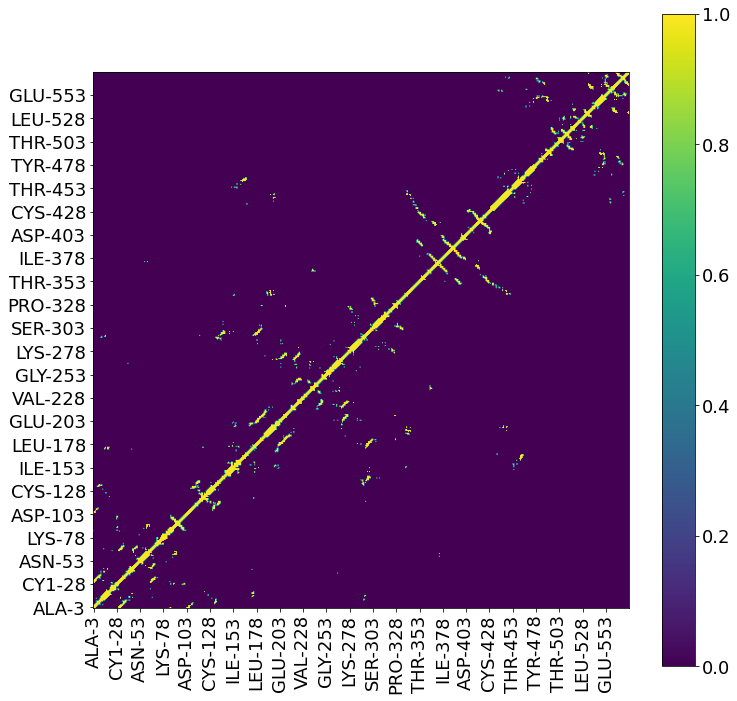

In [6]:
plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 18})
plt.imshow(np.flip(cmap < .8,axis=1))
plt.colorbar()
xt = plt.xticks([25*i for i in range(23)],res_names[::25],rotation=90)
yt = plt.yticks([(574-25*i) for i in range(23)],(res_names[::25]))

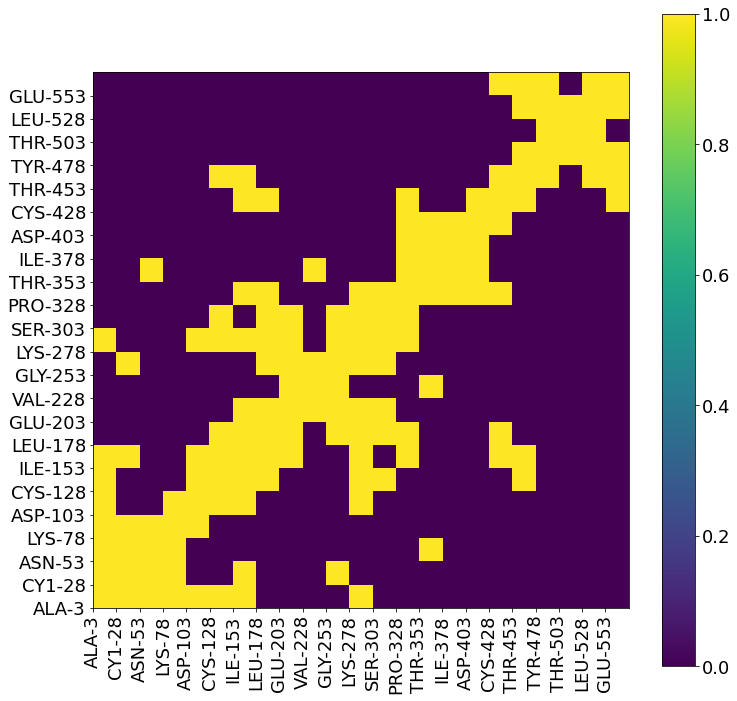

In [7]:
plt.figure(figsize=(12,12))
plt.imshow( np.flip(pool_arr(cmap),axis=1))
plt.colorbar()
xt = plt.xticks([i-0.5 for i in range(23)],res_names[::25],rotation=90)
yt = plt.yticks([(22.5-i) for i in range(23)],(res_names[::25]))

In [10]:
import os
if os.path.isfile("./z_dict.p"):
    with open("z_dict.p","rb") as f:
        z_dict = p.load(f)
else:
    z_dict = {}
with torch.no_grad():
    for dkey,dset in hdf["data"].items():
        if dkey not in z_dict.keys():
            print(f"Working on {dkey}..")
            z_dict.setdefault(dkey,[])
            for x in tqdm(dset):
                x = pool_arr(x)
                x = torch.tensor(x).view(1,1,23,23).float()
                z = np.array(nn(x)[-1])
                z_dict[dkey].append(z)
            with open("z_dict.p","wb") as f:
                p.dump(z_dict,f)

Working on APO_helicase_140mM.pdb-5-cmaps..


100%|██████████| 10000/10000 [04:45<00:00, 34.97it/s]


Working on APO_helicase_6JYT_140mM.pdb-4-cmaps..


100%|██████████| 10000/10000 [05:13<00:00, 31.89it/s]


Working on APO_helicase_minimal_salt.pdb-6-cmaps..


100%|██████████| 15000/15000 [10:40<00:00, 23.42it/s]


Working on ATP_start.pdb-7-cmaps..


100%|██████████| 30002/30002 [21:22<00:00, 23.40it/s]


Working on ATP_start.pdb-8-cmaps..


100%|██████████| 30002/30002 [21:24<00:00, 23.36it/s]


Working on ATP_start.pdb-9-cmaps..


100%|██████████| 10001/10001 [07:08<00:00, 23.36it/s]


Working on ATP_step3_charmm2namd.psf-10-cmaps..


100%|██████████| 1000/1000 [00:43<00:00, 23.18it/s]


Working on ATP_step3_charmm2namd.psf-11-cmaps..


100%|██████████| 1000/1000 [00:42<00:00, 23.61it/s]


Working on ATP_step3_charmm2namd.psf-12-cmaps..


100%|██████████| 1000/1000 [00:42<00:00, 23.34it/s]


Working on ATP_step3_charmm2namd.psf-13-cmaps..


100%|██████████| 1000/1000 [00:42<00:00, 23.27it/s]


Working on ATP_step3_charmm2namd.psf-14-cmaps..


100%|██████████| 1000/1000 [00:42<00:00, 23.33it/s]


In [16]:
for k,v in z_dict.items():
    print(k,len(v),len(v[0][0]))

APO_helicase_140mM.pdb-5-cmaps 10000 10
APO_helicase_6JYT_140mM.pdb-4-cmaps 10000 10
APO_helicase_minimal_salt.pdb-6-cmaps 15000 10
ATP_start.pdb-7-cmaps 30002 10
ATP_start.pdb-8-cmaps 30002 10
ATP_start.pdb-9-cmaps 10001 10
ATP_step3_charmm2namd.psf-10-cmaps 1000 10
ATP_step3_charmm2namd.psf-11-cmaps 1000 10
ATP_step3_charmm2namd.psf-12-cmaps 1000 10
ATP_step3_charmm2namd.psf-13-cmaps 1000 10
ATP_step3_charmm2namd.psf-14-cmaps 1000 10


In [12]:
from sklearn.manifold import TSNE

In [15]:
v[0].shape

(1, 10)

In [24]:
x = [v for v in z_dict.values()]
x = np.vstack(x)
x = x.reshape(-1,10)
tsne = TSNE()
trans = tsne.fit_transform(x)

In [26]:
trans.shape

(110005, 2)

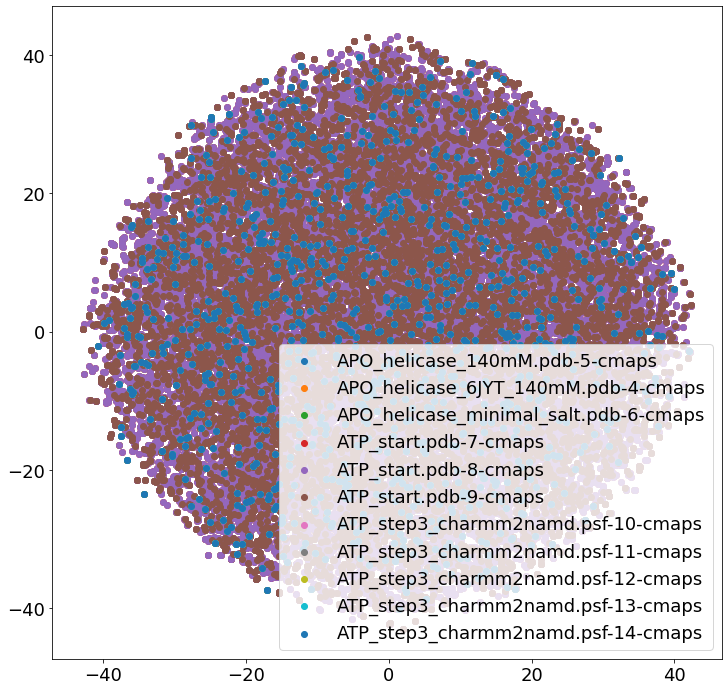

In [34]:
plt.figure(figsize=(12,12))
prev = 0
for k,v in z_dict.items():
    cur = prev + len(v)
    plt.scatter(trans[:,0][prev:cur],trans[:,1][prev:cur],label=k)
plt.legend()